In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
from transformers import LevitForImageClassification, LevitConfig
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from torchvision import models

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/ML Project - Dump/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/train/fake/1S3ANFPE1N.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1S5FVEAHIC.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1S6ZHTU2AP.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1S8QH0FQYD.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1S91T948PV.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1SA5PQJCNS.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1SAXGCOVUV.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1SBJOHAQBU.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1SC7JSNN4P.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1SCWBXWA7Z.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1SDB62Q7X5.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1SDE9WANE2.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1SFVQIO6C4.jpg  
  inflating: real_vs_fake/real-vs-fake/train/fake/1SGKHIALWN.jpg  
  inflating

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Function to get predictions and probabilities
def get_predictions_and_probabilities(model, dataloader):
    model.eval()
    predictions = []
    actuals = []
    probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating {model.__class__.__name__}", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits
            probs = softmax(outputs, dim=1)[:, 1]  # Probability for class '1'
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.view(-1).cpu().numpy())
            actuals.extend(labels.view(-1).cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    return predictions, actuals, probabilities


Using device: cuda


In [ ]:


# Load pre-trained model configuration
config3 = LevitConfig.from_pretrained("facebook/levit-128S")
config3.num_labels = 2  # Update number of classes

# Load pre-trained model with updated configuration
model3 = LevitForImageClassification(config=config3)

# Load your custom trained weights for the model
model3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project - Dump/final_model_scartch_LeViT_state.pth', map_location=device), strict=False)
model3.to(device)



config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

LevitForImageClassification(
  (levit): LevitModel(
    (patch_embeddings): LevitPatchEmbeddings(
      (embedding_layer_1): LevitConvEmbeddings(
        (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_1): Hardswish()
      (embedding_layer_2): LevitConvEmbeddings(
        (convolution): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_2): Hardswish()
      (embedding_layer_3): LevitConvEmbeddings(
        (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_3): Hardswish()
      

In [ ]:
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

test_dataset = RealVFakeDataset('/content/real_vs_fake/real-vs-fake/test', transform)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:

# Get predictions and actuals for each model
predictions3, actuals3, probabilities3 = get_predictions_and_probabilities(model3, test_loader)


Evaluating LevitForImageClassification: 100%|██████████| 625/625 [01:26<00:00,  7.23batch/s]


Model 3 test Accuracy: 0.9183
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10000
           1       0.89      0.95      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Model 3 - AUC Score: 0.97997872 AP Score: 0.9819724552471362


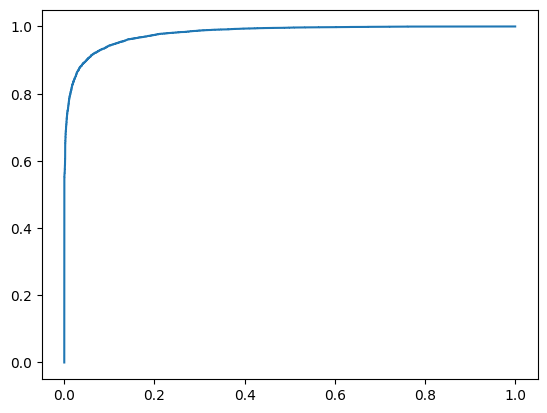

In [ ]:
accuracy3 = accuracy_score(actuals3, predictions3)
print("Model 3 test Accuracy:", accuracy3)
print(classification_report(actuals3, predictions3))


auc_score3 = roc_auc_score(actuals3, probabilities3)
ap_score3 = average_precision_score(actuals3, probabilities3)
print("Model 3 - AUC Score:", auc_score3, "AP Score:", ap_score3)

fpr3, tpr3, _ = roc_curve(actuals3, probabilities3)
plt.plot(fpr3, tpr3, label='Model 3')